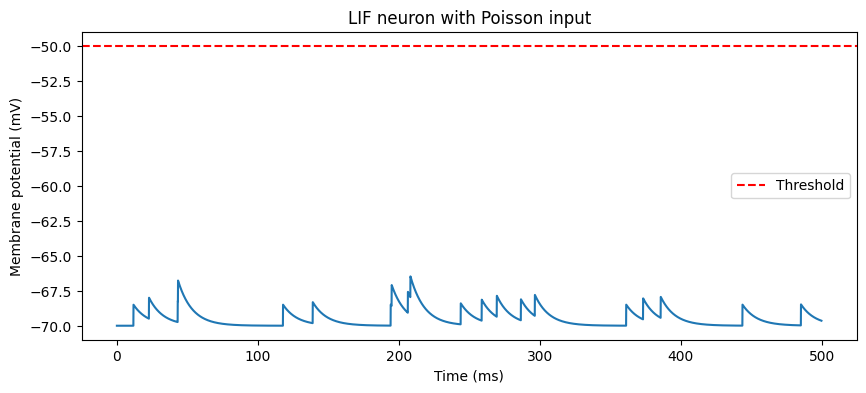

Spike times: [] s


In [1]:
from brian2 import *

# Simulation settings
start_scope()
defaultclock.dt = 0.1*ms
duration = 500*ms

# Neuron parameters
tau = 10*ms
v_rest = -70*mV
v_reset = -65*mV
v_thresh = -50*mV

# LIF neuron model
eqs = '''
dv/dt = (v_rest - v) / tau : volt
'''

neuron = NeuronGroup(1, eqs,
                     threshold='v > v_thresh',
                     reset='v = v_reset',
                     method='exact')

neuron.v = v_rest

# Poisson input
input = PoissonGroup(1, rates=50*Hz)
syn = Synapses(input, neuron, on_pre='v += 1.5*mV')
syn.connect()

# Monitor
mon = StateMonitor(neuron, 'v', record=True)
spikes = SpikeMonitor(neuron)

# Run it!
run(duration)

# Plot it!
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(mon.t/ms, mon.v[0]/mV)
plt.axhline(y=v_thresh/mV, color='r', linestyle='--', label='Threshold')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('LIF neuron with Poisson input')
plt.legend()
plt.show()

# Print spikes
print(f"Spike times: {spikes.t[:]}")


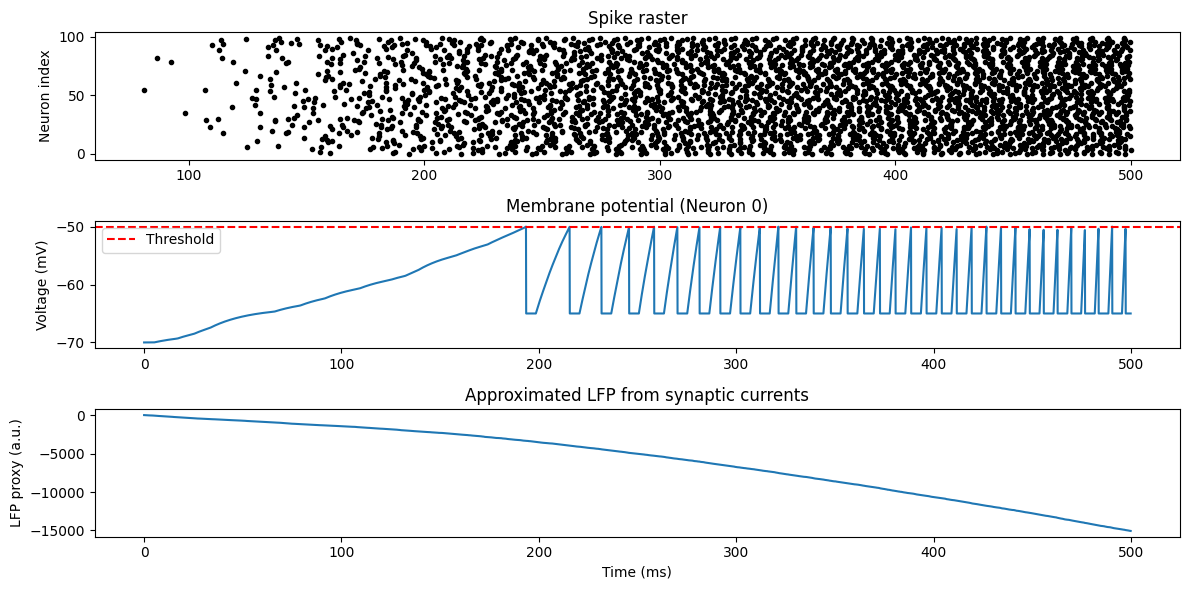

In [3]:
from brian2 import *

# Set up simulation parameters
start_scope()
N = 100                      # Number of neurons
duration = 500*ms
defaultclock.dt = 0.1*ms

# Neuron model (LIF)
tau = 20*ms
v_rest = -70*mV
v_reset = -65*mV
v_thresh = -50*mV
refractory_period = 5*ms

eqs = '''
dv/dt = (v_rest - v + I_syn) / tau : volt (unless refractory)
I_syn : volt
'''

neurons = NeuronGroup(N, eqs, 
                      threshold='v > v_thresh', 
                      reset='v = v_reset',
                      refractory=refractory_period,
                      method='euler')
neurons.v = v_rest
neurons.I_syn = 0*mV

# Poisson input
poisson_input = PoissonGroup(N, rates=100*Hz)
input_syn = Synapses(poisson_input, neurons, on_pre='I_syn += 1.5*mV')
input_syn.connect(j='i')  # One-to-one input

# Recurrent synapses
recurrent = Synapses(neurons, neurons, on_pre='I_syn += 0.5*mV')
recurrent.connect(condition='i != j', p=0.05)  # No self-connections

# Monitors
spikemon = SpikeMonitor(neurons)
statemon = StateMonitor(neurons, 'v', record=0)  # Only record one neuron’s voltage
synmon = StateMonitor(neurons, 'I_syn', record=True)

# Run simulation
run(duration)

# Approximate LFP: sum of synaptic currents over all neurons
lfp = -sum(synmon.I_syn / mV, axis=0)  # Negative sum as proxy for LFP

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Raster plot
plt.subplot(3, 1, 1)
plt.plot(spikemon.t/ms, spikemon.i, '.k')
plt.ylabel('Neuron index')
plt.title('Spike raster')

# Single neuron membrane potential
plt.subplot(3, 1, 2)
plt.plot(statemon.t/ms, statemon.v[0]/mV)
plt.axhline(y=v_thresh/mV, color='r', linestyle='--', label='Threshold')
plt.ylabel('Voltage (mV)')
plt.legend()
plt.title('Membrane potential (Neuron 0)')

# LFP approximation
plt.subplot(3, 1, 3)
plt.plot(synmon.t/ms, lfp)
plt.xlabel('Time (ms)')
plt.ylabel('LFP proxy (a.u.)')
plt.title('Approximated LFP from synaptic currents')

plt.tight_layout()
plt.show()


WARNING    'g_exc' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value array([[0.        , 0.        , 0.        , ..., 0.00817183, 0.00800839,
        1.00784822],
       [0.        , 0.        , 0.        , ..., 0.07924691, 0.07766197,
        0.07610873],
       [0.        , 0.        , 0.        , ..., 0.15467115, 0.15157773,
        0.14854617],
       ...,
       [0.        , 0.        , 0.        , ..., 0.11469578, 0.11240187,
        0.11015383],
       [0.        , 0.        , 0.        , ..., 0.07703389, 0.07549321,
        0.07398335],
       [0.        , 0.        , 0.        , ..., 0.27445369, 0.26896462,
        0.26358532]]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'g_inh' is an internal variable of group 'neurongroup_4', but also exists in the run namespace with the value array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 

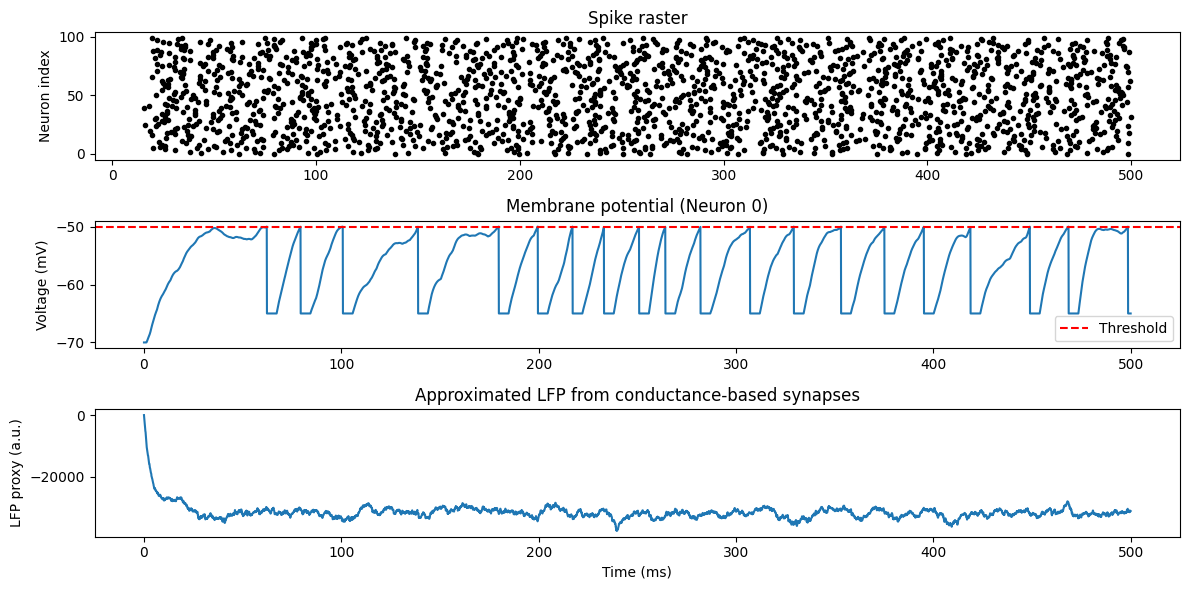

In [6]:
from brian2 import *

start_scope()
defaultclock.dt = 0.1*ms
duration = 500*ms
N = 100

# Reversal potentials
E_exc = 0*mV
E_inh = -80*mV

g_leak = 10 * nS  # leak conductance
E_leak = -70 * mV

# Corrected conductance-based LIF neuron model
eqs = '''
dv/dt = (g_leak*(E_leak - v) + g_exc*(E_exc - v) + g_inh*(E_inh - v)) / C : volt (unless refractory)
dg_exc/dt = -g_exc / tau_exc : siemens
dg_inh/dt = -g_inh / tau_inh : siemens
'''

C = 200 * pF  # membrane capacitance


# Parameters
tau = 20*ms
v_rest = -70*mV
v_reset = -65*mV
v_thresh = -50*mV
refractory_period = 5*ms

tau_exc = 5*ms
tau_inh = 10*ms

# Create neurons
neurons = NeuronGroup(N, eqs,
                      threshold='v > v_thresh',
                      reset='v = v_reset',
                      refractory=refractory_period,
                      method='euler')
neurons.v = v_rest
neurons.g_exc = 0*nS
neurons.g_inh = 0*nS

# External Poisson input
input = PoissonGroup(N, rates=100*Hz)
input_syn = Synapses(input, neurons, on_pre='g_exc += 1*nS')
input_syn.connect(j='i')

# Recurrent connectivity
recurrent_exc = Synapses(neurons, neurons, on_pre='g_exc += 0.5*nS')
recurrent_exc.connect(condition='i != j', p=0.05)

# Optional inhibitory neurons
# Could split the population into E/I later

# Monitors
spikemon = SpikeMonitor(neurons)
statemon = StateMonitor(neurons, 'v', record=0)
conductance_mon = StateMonitor(neurons, ['g_exc', 'g_inh', 'v'], record=True)

# Run simulation
run(duration)

# Compute LFP approximation: sum of synaptic currents across all neurons
v = conductance_mon.v / mV
g_exc = conductance_mon.g_exc / nS
g_inh = conductance_mon.g_inh / nS

I_exc = g_exc * (E_exc/mV - v)
I_inh = g_inh * (E_inh/mV - v)
lfp_proxy = -np.sum(I_exc + I_inh, axis=0)

# Plot everything
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Spike raster
plt.subplot(3, 1, 1)
plt.plot(spikemon.t/ms, spikemon.i, '.k')
plt.ylabel('Neuron index')
plt.title('Spike raster')

# Membrane potential of neuron 0
plt.subplot(3, 1, 2)
plt.plot(statemon.t/ms, statemon.v[0]/mV)
plt.axhline(y=v_thresh/mV, color='r', linestyle='--', label='Threshold')
plt.ylabel('Voltage (mV)')
plt.title('Membrane potential (Neuron 0)')
plt.legend()

# LFP proxy
plt.subplot(3, 1, 3)
plt.plot(conductance_mon.t/ms, lfp_proxy)
plt.xlabel('Time (ms)')
plt.ylabel('LFP proxy (a.u.)')
plt.title('Approximated LFP from conductance-based synapses')

plt.tight_layout()
plt.show()
